In [ ]:

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import time

In [3]:
s = set() 
s.add('occupancy_6005')
s.add('occupancy_t4013')
s.add('speed_6005')
s.add('speed_7578')
s.add('speed_t4013')
s.add('TravelTime_387')
s.add('TravelTime_451')

In [4]:
for x in s:
    exec(x + " = pd.read_csv('" + x + ".csv', parse_dates=True, index_col='timestamp')")

In [5]:
for x in s:
    exec(x +" = " + x + ".rename(columns={'value': x})")

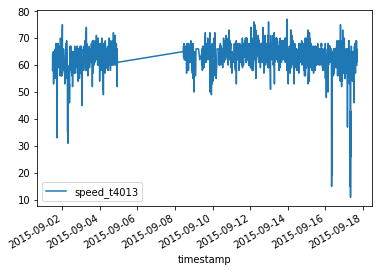

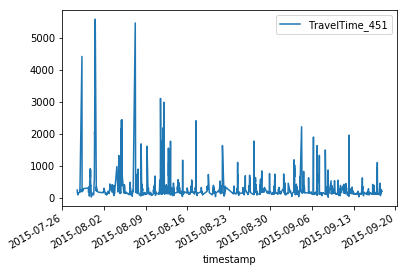

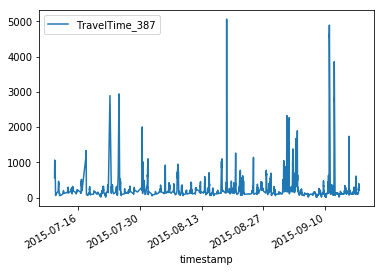

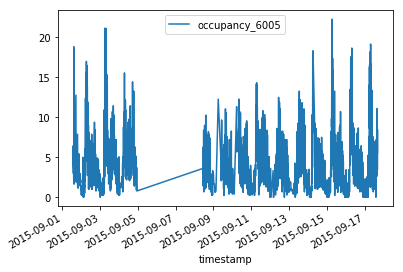

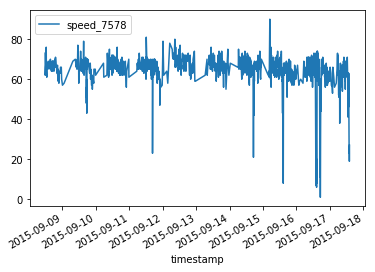

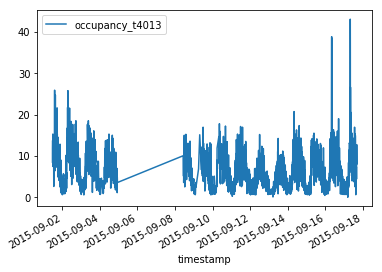

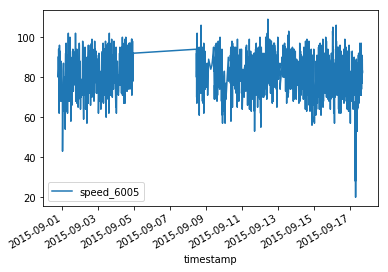

In [6]:
for x in s:
    exec(x +".plot()")

In [7]:
for x in s:
    exec(x + " = " + x + ".resample('H').mean()")

In [8]:
occ = pd.concat([occupancy_6005, occupancy_t4013], axis = 1)
spd = pd.concat([speed_6005, speed_7578, speed_t4013], axis = 1)
tti = pd.concat([TravelTime_387, TravelTime_451], axis = 1)

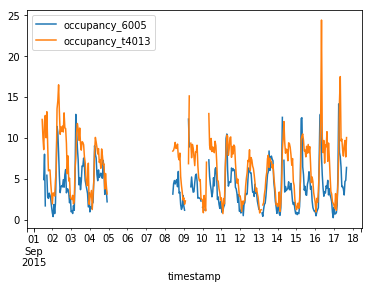

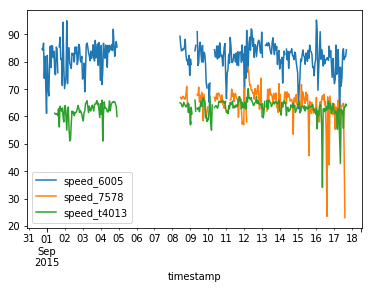

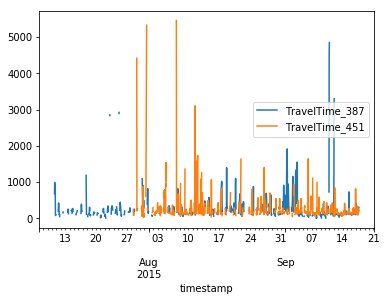

In [9]:
occ.plot()
spd.plot()
tti.plot()

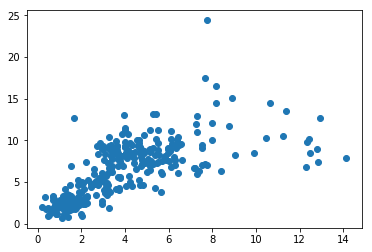

In [10]:
plt.scatter(x = occ['occupancy_6005'], y = occ['occupancy_t4013'])

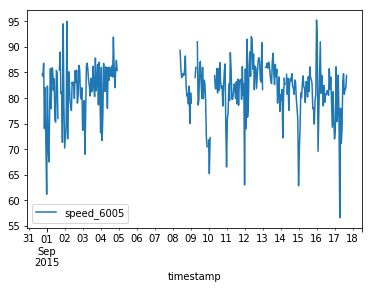

In [11]:
speed_6005.plot()

# ARIMA: Occupancy and Speed Analysis

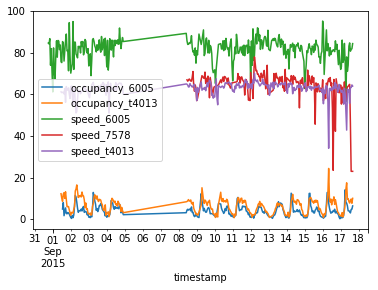

In [12]:
# We eill be working just with these three variables, because they are equally available during certain period of time
data_all = pd.concat([occupancy_6005, occupancy_t4013, speed_6005, speed_7578, speed_t4013], axis = 1)
dataseq = data_all.resample('H').bfill().interpolate()
dataseq.plot()

We are subsetting the data due to the gap between the data provided

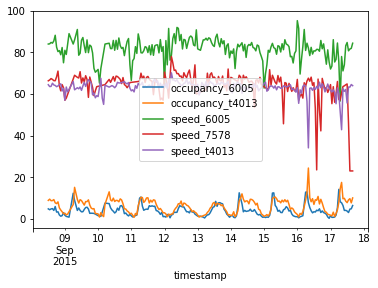

In [13]:
import datetime as dt # Imports dates library 
a = dt.datetime(2015, 9, 8, 12) # Fixes the start date 
seldata = dataseq[a:] # Subsets the data
seldata.plot()

In [14]:
seldata.corr()

,occupancy_6005,occupancy_t4013,speed_6005,speed_7578,speed_t4013
occupancy_6005,1.000000,0.687950,0.203651,0.079921,-0.051443
occupancy_t4013,0.687950,1.000000,0.198214,0.004306,-0.259377
speed_6005,0.203651,0.198214,1.000000,0.112409,0.262239
speed_7578,0.079921,0.004306,0.112409,1.000000,0.114079
speed_t4013,-0.051443,-0.259377,0.262239,0.114079,1.000000


In [15]:
one_var = seldata['speed_7578']
print(one_var.head())

timestamp
2015-09-08 12:00:00    66.333333
2015-09-08 13:00:00    66.750000
2015-09-08 14:00:00    67.400000
2015-09-08 15:00:00    67.000000
2015-09-08 16:00:00    66.400000
Freq: H, Name: speed_7578, dtype: float64


To fit the _ARIMA_ model we are determining the parameters by a grid search, and minimizing the API coeficient

In [16]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages
# Chooses the adequated AIC attending to the 
AIC = -1
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(one_var,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

            results = mod.fit()
            if (AIC == -1 or AIC > results.aic):
                print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
                AIC = results.aic
                c_param = param
                c_param_seasonal = param_seasonal
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:1995.3653770783526
ARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:1145.3193704040095
ARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:1106.0560265898976
ARIMA(0, 1, 1)x(0, 1, 1, 24)24 - AIC:1084.1053225968194
ARIMA(1, 1, 1)x(0, 1, 1, 24)24 - AIC:1080.6333899481028


In [19]:
c_mod = SARIMAX(one_var,
                order=c_param,
                seasonal_order=c_param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = c_mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4191      0.096      4.348      0.000       0.230       0.608
ma.L1         -0.9304      0.069    -13.566      0.000      -1.065      -0.796
ma.S.L24      -0.4612      0.036    -12.913      0.000      -0.531      -0.391
sigma2        31.9391      1.621     19.705      0.000      28.762      35.116


The plots below shoud aknowledge Residuals normality:
- The standarized residuals should appear to be white noise
- The histogram should show that the residuals are normaly distributed
- The Q-Q plot should also confirm the normal distribution
- The correlogram should show no correlation left on the residuals

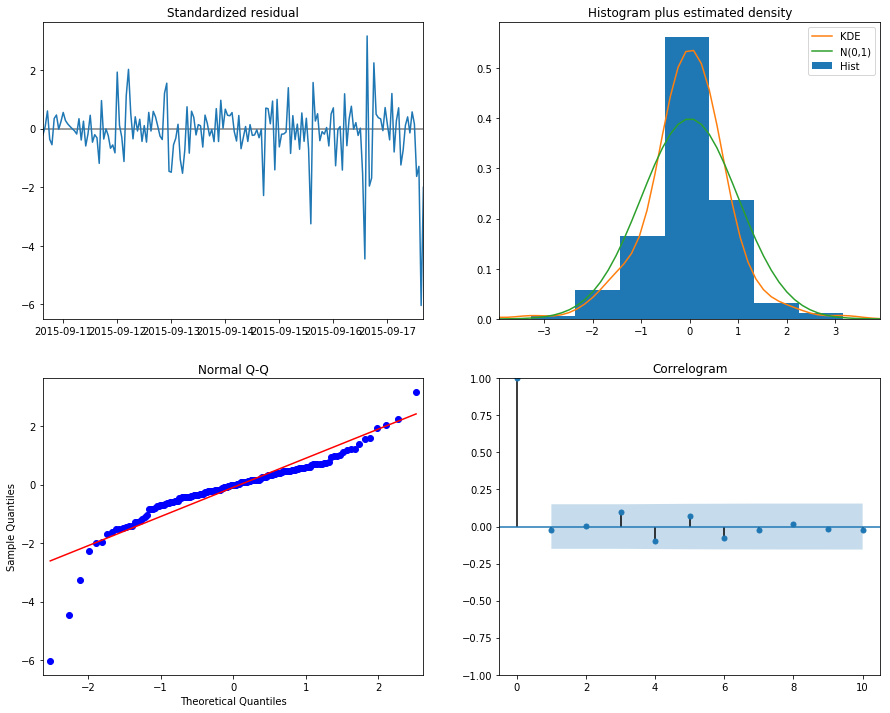

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2015-09-12'), dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)

In [31]:
DF = pd.concat([x, pred_ci], axis=1)

In [32]:
DF['Flag_Anomaly'] = (DF['speed_7578'] > DF['upper speed_7578']) | (DF['speed_7578'] < DF['lower speed_7578'])

In [33]:
DF['Anomaly'] = DF['speed_7578'] * DF['Flag_Anomaly']

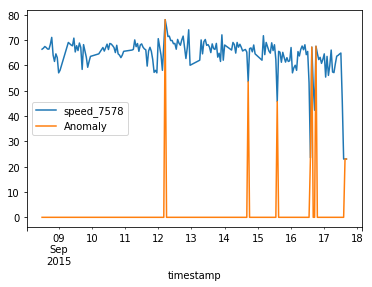

In [34]:
DF[['speed_7578','Anomaly']].plot()

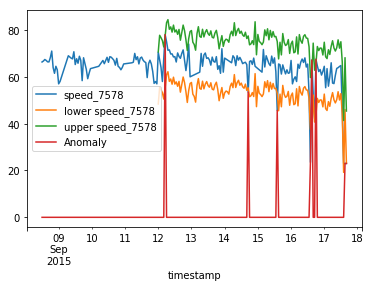

In [35]:
DF.plot()

# ARIMA Univariate routine

Variables available 
- occupancy_6005
- occupancy_t4013
- speed_6005
- speed_7578
- speed_t4013

In [36]:
var_chosen = 'occupancy_t4013'

one_var = seldata[var_chosen]

In [37]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

from statsmodels.tsa.statespace.sarimax import SARIMAX

#warnings.filterwarnings("ignore") # specify to ignore warning messages
# Chooses the adequated parameters attending to the AIC
AIC = -1
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(one_var,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

            results = mod.fit()
            if (AIC == -1 or AIC > results.aic):
                print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
                AIC = results.aic
                c_param = param
                c_param_seasonal = param_seasonal
        except:
            continue

# Prints the ARIMA model Results      
c_mod = SARIMAX(one_var,
                order=c_param,
                seasonal_order=c_param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = c_mod.fit()

print(results.summary().tables[1])

ARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:1148.72693558329
ARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:738.4618782241256
ARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:696.2225008484481
ARIMA(0, 1, 1)x(0, 1, 1, 24)24 - AIC:683.6680041132745
ARIMA(1, 0, 0)x(0, 1, 1, 24)24 - AIC:679.3898605223558
ARIMA(1, 0, 1)x(0, 1, 1, 24)24 - AIC:673.8546191097216
ARIMA(1, 1, 1)x(0, 1, 1, 24)24 - AIC:673.3198107611654
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4645      0.071      6.576      0.000       0.326       0.603
ma.L1         -0.9385      0.051    -18.275      0.000      -1.039      -0.838
ma.S.L24      -0.4944      0.071     -6.980      0.000      -0.633      -0.356
sigma2         2.9017      0.107     27.056      0.000       2.691       3.112


The plots below shoud aknowledge Residuals normality:
- The standarized residuals should appear to be white noise
- The histogram should show that the residuals are normaly distributed
- The Q-Q plot should also confirm the normal distribution
- The correlogram should show no correlation left on the residuals

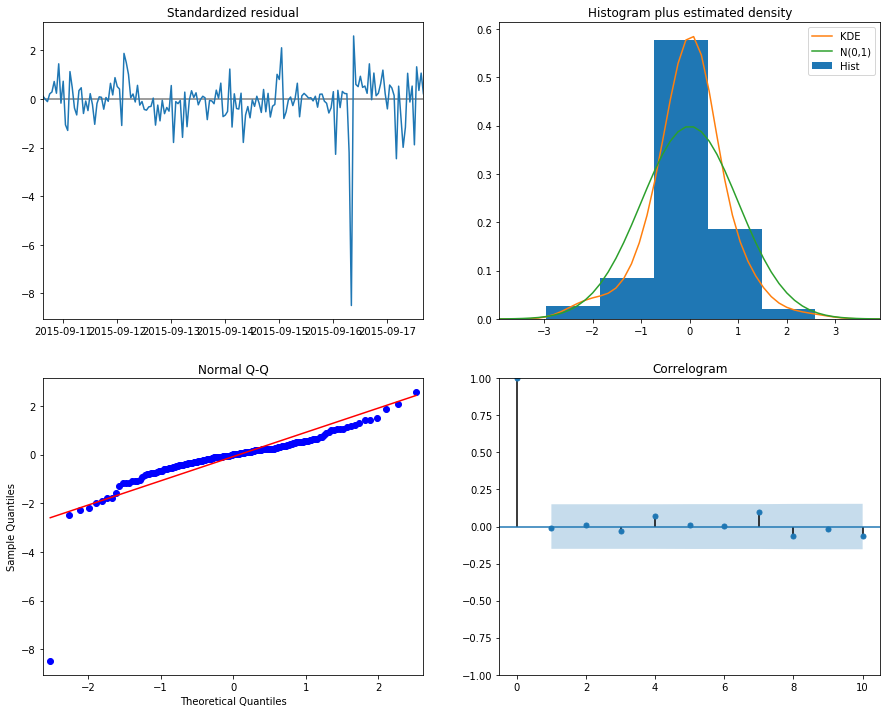

In [144]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

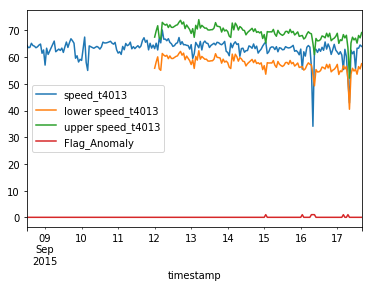

In [145]:
pred = results.get_prediction(start=pd.to_datetime('2015-09-12'), dynamic=False)
pred_ci = pred.conf_int(alpha=0.05)
x = pd.DataFrame(one_var)
DF = pd.concat([x, pred_ci], axis=1)
DF['Flag_Anomaly'] = (DF[var_chosen] > DF['upper ' + var_chosen]) | (DF[var_chosen] < DF['lower ' + var_chosen])
DF.plot()
DF['Anomaly'] = DF[var_chosen] * DF['Flag_Anomaly']

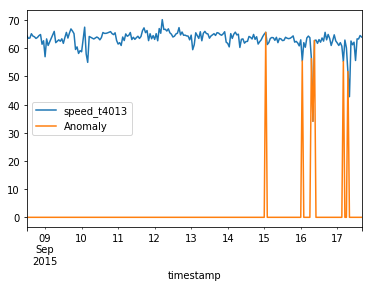

In [147]:
DF[[var_chosen,'Anomaly']].plot()

In [49]:
x = x.dropna(how='any')

In [50]:
x.head()

,occupancy_6005,occupancy_t4013,speed_6005,speed_7578,speed_t4013
timestamp,,,,,
2015-09-09 13:00:00,0.467778,-1.623000,1.198413,2.047619,2.938889
2015-09-09 14:00:00,0.736667,-0.369323,-4.642857,-2.564286,1.755556
2015-09-09 15:00:00,0.720000,1.605795,-2.908369,3.377778,-3.541667
2015-09-09 16:00:00,1.047667,-0.499583,5.019481,-1.177778,2.608333
2015-09-09 17:00:00,-2.740206,2.414356,-8.865079,-8.600000,1.717424


In [53]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.statespace.sarimax as sm 

C:\Users\Alvaro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [59]:
test = seldata['occupancy_6005']

## Trying with SARIMA with no success

In [79]:
seldata.tail()

,occupancy_6005,occupancy_t4013,speed_6005,speed_7578,speed_t4013
timestamp,,,,,
2015-09-17 12:00:00,3.707500,7.755833,84.750000,64.818182,55.666667
2015-09-17 13:00:00,3.001667,9.069167,80.750000,46.083333,63.333333
2015-09-17 14:00:00,4.666923,9.669231,81.615385,23.000000,63.307692
2015-09-17 15:00:00,4.781538,7.654615,81.923077,23.000000,64.538462
2015-09-17 16:00:00,6.368000,10.022000,84.400000,23.000000,64.000000


In [108]:
res = fited.predict(start=dt.datetime(2015, 9, 17, 12), end=dt.datetime(2015, 9, 19, 12))


In [163]:
from statsmodels.tsa.arima_model import ARIMA

In [168]:
data = seldata['occupancy_6005']

In [169]:
size = int(len(data) * 0.33)
train, test = data[0:size], data[size:len(data)]

In [172]:
history = [x for x in train]

In [175]:
from sklearn.metrics import mean_squared_error
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=6.429265, expected=4.540000
predicted=3.973147, expected=6.302727
predicted=6.300129, expected=5.963333
predicted=5.981823, expected=6.234000
predicted=5.973776, expected=5.972500
predicted=6.003617, expected=6.051667
predicted=5.910394, expected=3.932727
predicted=3.636814, expected=3.757500
predicted=3.880559, expected=3.158750
predicted=3.501940, expected=2.105714
predicted=2.154861, expected=3.058333
predicted=3.617059, expected=1.024000
predicted=0.868562, expected=1.121667
predicted=1.227937, expected=0.796667
predicted=1.117719, expected=2.055000
predicted=2.322140, expected=1.915000
predicted=2.015160, expected=0.472500
predicted=0.004304, expected=1.844000
predicted=2.103235, expected=2.068000
predicted=2.164354, expected=3.216250
predicted=3.232135, expected=3.055556
predicted=2.897494, expected=3.122222
predicted=2.784382, expected=4.903636
predicted=5.096680, expected=6.308182
predicted=6.318925, expected=5.973000
predicted=5.487980, expected=5.715000
predicted=5.

NameError: name 'pyplot' is not defined

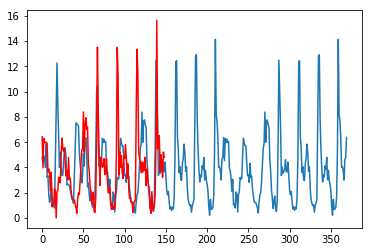

In [180]:
# plot
plt.plot(history)
plt.plot(predictions, color='red')
plt.show()

In [98]:
res = res.rename(columns = valuedd)
x +" = " + x + ".rename(columns={'value': x})"

SyntaxError: invalid syntax (<ipython-input-98-61bd23eac4a9>, line 1)

In [33]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [24]:
help(dt.datetime)

Help on class datetime in module datetime:

class datetime(date)
 |  datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
 |  
 |  The year, month and day arguments are required. tzinfo may be None, or an
 |  instance of a tzinfo subclass. The remaining arguments may be ints.
 |  
 |  Method resolution order:
 |      datetime
 |      date
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __new__(*args, **kwa

# Fuzzy c-means: Occupation Data

In this part of the Notebook we intend to evaluate the fuzzy means algorithms in order to group the data of the occupation sensors

Fix general parameter

In [277]:
# Fix number of Fuzzy clusters
c = 5
# Fix weighting exponent
m = 1.5
# Fix convergence criteria
eps = 1e-5

In [169]:
#First of all remove datapoints with Nan
data = occ.dropna(how='any')
# Normalize data
data = (data - data.mean())/data.std()

In [170]:
print(occ.shape)
print(data.shape)

(390, 2)
(290, 2)


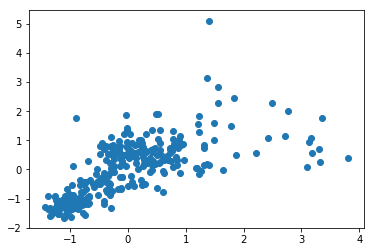

In [171]:
plt.scatter(x = data['occupancy_6005'], y = data['occupancy_t4013'])

In [213]:
#compute the number of observations
N = data.shape[0]
#compute the number of dimensions
n = data.shape[1]

In [197]:
# Create initial Randomized Pertenance Matrix 
U = np.random.rand(c,N)
U = U/sum(U)
# Transfer data to NumPy Matrix
data_mat = data.as_matrix()

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


C:\Users\Alvaro\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


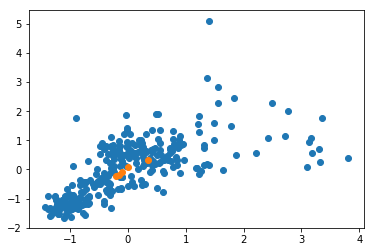

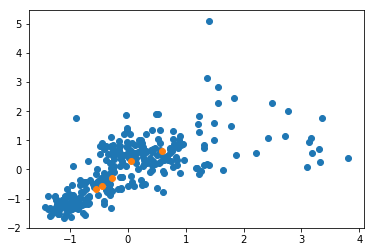

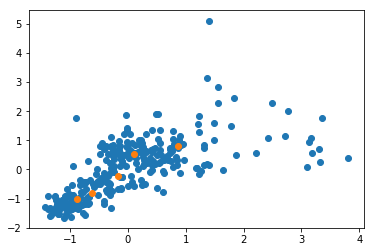

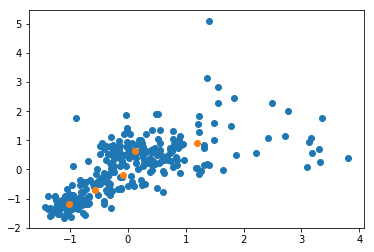

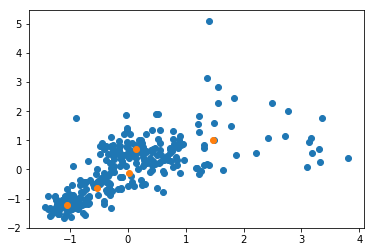

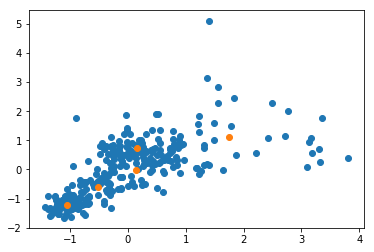

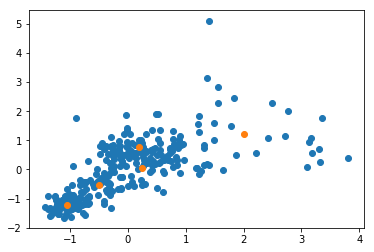

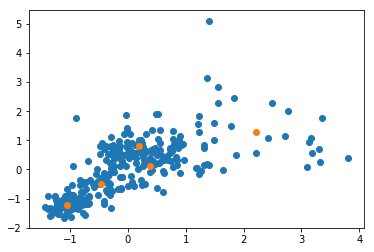

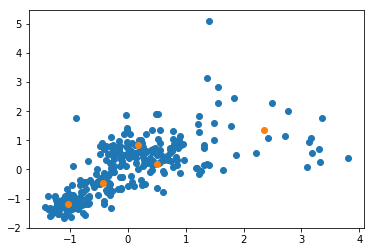

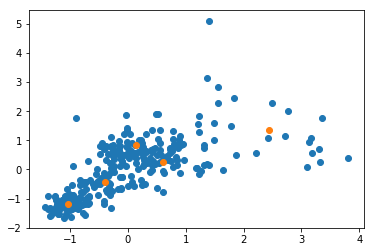

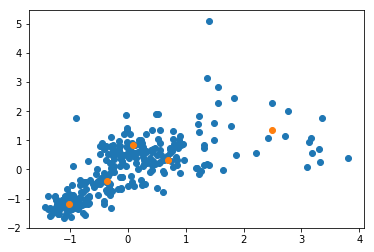

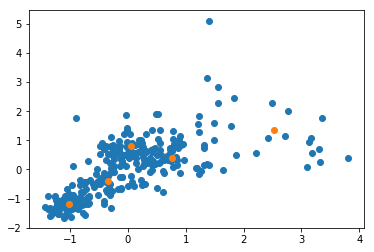

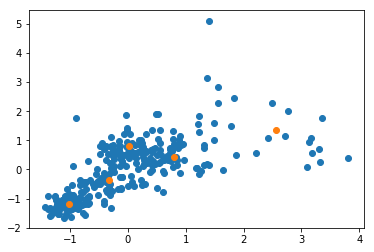

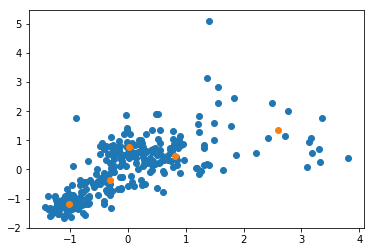

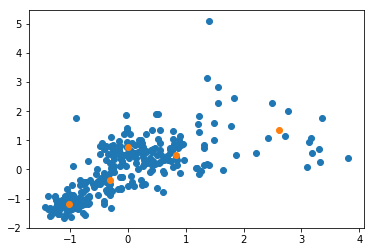

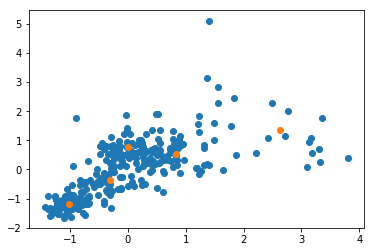

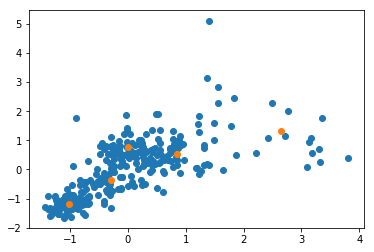

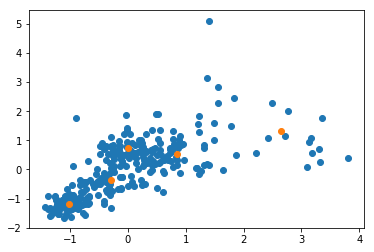

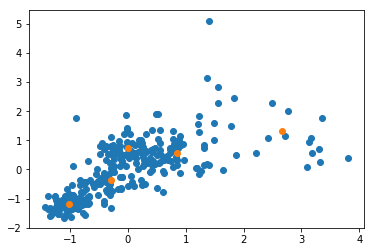

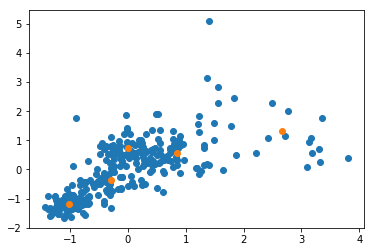

In [280]:
while (np.linalg.norm(U-U_1) > 0.1):
    U = U_1
    # Matrix of uik ^m 
    U_m = U**m
    # sum of all weights for each cluster 
    s_U = np.sum(U_m, axis = 1)
    # Predefine the matrix
    V = np.zeros([c, n])
    for x in range(c):
        V[x] = np.dot(U_m[x], data_mat)

    V_hat = np.transpose(V)/s_U
    # Compute distances from 
    D = np.zeros([c, N])
    for i in range(c):
        for k in range(N):
            D[i,k] = np.sum((V_hat[:,i] - data_mat[k,:])**2)

    #Actualizar la matriz de relaciones 
    D_exp = D**(1/(m-1))
    U_1 = np.zeros([c, N])
    for i in range(c):
        U_1[i, :] = np.sum(D_exp[i, :] / D_exp, axis = 0)**-1

    print(np.linalg.norm(U-U_1) < eps)

    plt.scatter(x=np.transpose(data_mat)[0,:], y = np.transpose(data_mat)[1,:])
    plt.scatter(x=V_hat[0,:], y = V_hat[1,:])
    plt.figure()

In [202]:
# Matrix of uik ^m 
U_m = U**m
# sum of all weights for each cluster 
s_U = np.sum(U_m, axis = 1)

In [215]:
# Predefine the matrix
V = np.zeros([c, n])
for x in range(c):
    V[x] = np.dot(U_m[x], data_mat)

In [224]:
V_hat = np.transpose(V)/s_U

In [250]:
# Compute distances from 
D = np.zeros([c, N])
for i in range(c):
    for k in range(N):
        D[i,k] = np.sum((V_hat[:,i] - data_mat[k,:])**2)

In [270]:
#Actualizar la matriz de relaciones 
D_exp = D**(1/(m-1))
U_1 = np.zeros([c, N])
for i in range(c):
    U_1[i, :] = np.sum(D_exp[i, :] / D_exp, axis = 0)**-1
    

In [278]:
np.linalg.norm(U-U_1) < eps

False

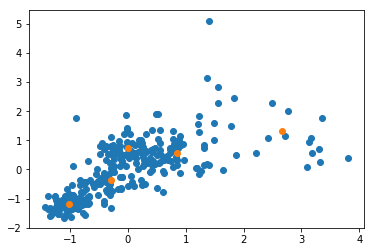

In [281]:

plt.scatter(x=np.transpose(data_mat)[0,:], y = np.transpose(data_mat)[1,:])
plt.scatter(x=V_hat[0,:], y = V_hat[1,:])

# Unusual time sequences

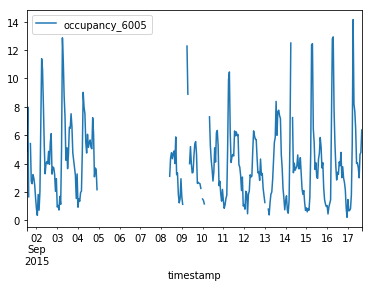

In [25]:
occupancy_6005.plot()

In [38]:
dataseq = speed_6005.resample('H').bfill().interpolate()

In [39]:
# Fix the desired longitude for the sequence we are searching
l = 24

In [40]:
S = dataseq.as_matrix()
S = S.transpose()
sl = S.shape[1]

In [41]:
def Normalize(X):
    return (X - X.mean())/X.std()

gnndis = 0
gnnarg = -1


start = time.time()

for x in range(sl - l + 1):
    if (abs(x-80)>= l and abs(x-167+l)>= l):# to resolve the big gap of data 
        dnn = -1
        Xv = S[0,x:(x+l)]
        Xv = Normalize(Xv)
        for y in range(sl - l + 1):
            if (abs(x-y)>= l):
                Yv = S[0,y:(y+l)]
                Yv = Normalize(Yv)
                Dxy = np.linalg.norm(Yv-Xv)
                if (Dxy < dnn or dnn == -1):
                    dnn = Dxy
                if (Dxy < gnndis):
                    break
        if (gnndis < dnn):
            gnnarg = x
            gnndis = dnn
            
end = time.time()
print(end - start)


1.186842441558838


In [42]:
gnnarg
pppt = pd.concat([dataseq, dataseq[gnnarg:(gnnarg+l)]], axis = 1)

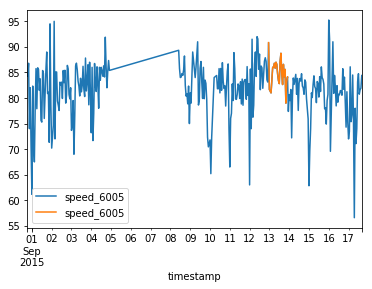

In [43]:
pppt.plot()

In [59]:
def Normalize(X):
    return (X - X.mean())/X.std()